## Word Embeddings for Fun and Profit
### Document classification with Gensim

In this tutorial we'll classify movie plots by genre using word embeddings techniques in [gensim](http://radimrehurek.com/gensim/) . 

See accompanying slides in this repo.

We will show how to get a __'hello-world'__ first untuned run using 7 techniques:

- Bag of words

- Character n-grams

- TF-IDF 

- Averaging word2vec vectors

- doc2vec

- Deep IR 

- Word Mover's Distance

The goal of this tutorial is to show the API so you can start tuning them yourself. Model tuning of the models is out of scope of this tutorial.

We will also compare the accuracy of this first 'no tuning'/out of the box run of these techniques. It is in no way an indication of their best peformance that can be achieved with proper tuning. The benefit of the comparison is to manage the expectations.

## Requirements

- Python 3
- [Google News pre-trained word2vec (1.5 GB)](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
- gensim
- sklearn
- pandas
- matplotlib
- nltk with English stopwords
- pyemd
- 4 GB RAM
- 8 GB disk space for WMD

## Dataset

We will use MovieLens dataset linked with plots from OMDB. Thanks to [Sujit Pal](http://sujitpal.blogspot.de/2016/04/predicting-movie-tags-from-plots-using.html) for this linking idea. The prepared csv is in this repository. If you wish to link the datasets yourself - see the code in the [blog]((http://sujitpal.blogspot.de/2016/04/predicting-movie-tags-from-plots-using.html).

In [14]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [120]:
from smart_open import smart_open
import pandas as pd
import numpy as np
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

%matplotlib inline

## Exploring the data



In [16]:
df = pd.read_csv('data/tagged_plots_movielens.csv')
df = df.dropna()

In [17]:
my_tags = ['sci-fi' , 'action', 'comedy', 'fantasy', 'animation', 'romance']

The dataset is only __170k__ words. It is quite small but makes sure we don't have to wait a long time for the code to complete.

In [18]:
df['plot'].apply(lambda x: len(x.split(' '))).sum()

171156

The data is very unbalanced. We have Comedy as majority class. 

A naive classifier that predicts everything to be comedy already achieves __40%__ accuracy.

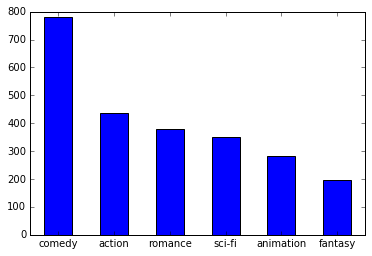

In [19]:
df.tag.value_counts().plot(kind="bar", rot=0)

The language in sci-fi plots differs a lot from romantic ones, so there should be some signal here.

In [20]:
def print_plot(movieId):
    example = df[df.movieId == movieId][['plot', 'tag']].values[0]
    print(example[0])
    print('Genre:', example[1])

In [21]:
print_plot(32)

In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.
Genre: sci-fi


In [22]:
print_plot(17)

When Mr. Dashwood dies, he must leave the bulk of his estate to the son by his first marriage, which leaves his second wife and their three daughters (Elinor, Marianne, and Margaret) in straitened circumstances. They are taken in by a kindly cousin, but their lack of fortune affects the marriageability of both practical Elinor and romantic Marianne. When Elinor forms an attachment for the wealthy Edward Ferrars, his family disapproves and separates them. And though Mrs. Jennings tries to match the worthy (and rich) Colonel Brandon to her, Marianne finds the dashing and fiery John Willoughby more to her taste. Both relationships are sorely tried.
Genre: romance


Train/test split of 90/10

In [23]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

## Model evaluation approach
We will use confusion matrices to evaluate all classifiers

In [24]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [26]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

## Baseline: bag of words, n-grams, tf-idf
Let's start with some simple baselines before diving into more advanced methods.

### Bag of words

The simplest document feature is just a count of each word occurrence in a document.

We remove stop-words and use NLTK tokenizer then limit our vocabulary to 3k most frequent words.

In [27]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [28]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])

CPU times: user 1.73 s, sys: 4.41 ms, total: 1.74 s
Wall time: 1.74 s


Multi-modal logistic regression is a simple white-box classifier. We will use either logistic regression or KNN throughout this tutorial.

In [29]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 366 ms, sys: 0 ns, total: 366 ms
Wall time: 368 ms


In [30]:
count_vectorizer.get_feature_names()[80:90]

['adventure',
 'adventures',
 'adventurous',
 'advice',
 'affair',
 'affairs',
 'affect',
 'afraid',
 'africa',
 'african']

Nothing impressive - only 2% better better than the classifier that thinks that everything is a comedy.

accuracy 0.423868312757
confusion matrix
 [[21  3  9  1  4  4]
 [ 3 11  8  1  3  5]
 [ 9 12 45  3 16  1]
 [ 2  6  2  3  2  1]
 [ 1  3 16  2 11  2]
 [ 8  5  6  2  0 12]]
(row=expected, col=predicted)
CPU times: user 401 ms, sys: 2.89 ms, total: 403 ms
Wall time: 406 ms


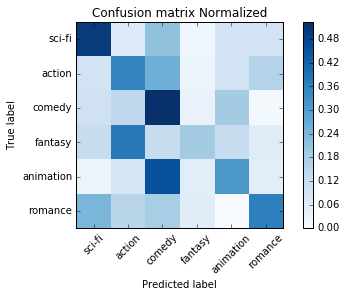

In [31]:
%%time

predict(count_vectorizer, logreg, test_data)

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [32]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]    

In [33]:
# words for the fantasy genre
fantasy_tag_id = 3
print(my_tags[fantasy_tag_id])
most_influential_words(count_vectorizer, fantasy_tag_id)

fantasy


['national',
 'chosen',
 'princess',
 'fan',
 'kingdom',
 'prove',
 'beast',
 'moving',
 'fantasies',
 'thief']

In [64]:
train_data_features[0]

<1x3000 sparse matrix of type '<type 'numpy.int64'>'
	with 44 stored elements in Compressed Sparse Row format>

### Character N-grams

A character _n-gram_ is a chunk of a document of length _n_. It is a poor man's tokenizer but sometimes works well. The parameter _n_ depends on language and the corpus. We choose length between 3 and 6 characters and to only focus on 3k most popular ones.

In [34]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([5,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])

logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 2.69 s, sys: 26.8 ms, total: 2.72 s
Wall time: 2.73 s


In [35]:
n_gram_vectorizer.get_feature_names()[50:60]

[' acti',
 ' adve',
 ' afte',
 ' agai',
 ' agen',
 ' alie',
 ' all ',
 ' alon',
 ' also',
 ' alwa']

The results are worse than using a tokenizer and bag of words. Probably due to not removing the stop words.

accuracy 0.41975308642
confusion matrix
 [[19  4 11  0  6  2]
 [ 5  7 10  3  3  3]
 [14  7 45  4 14  2]
 [ 2  1  2  4  3  4]
 [ 7  2 12  2 10  2]
 [ 3  1  4  5  3 17]]
(row=expected, col=predicted)


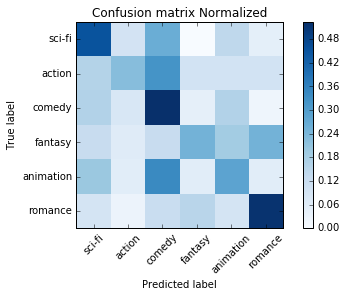

In [37]:
predict(n_gram_vectorizer, logreg, test_data)

### TF-IDF

[Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a little more advanced way to count words in a document.
It adjusts for document length, word frequency and most importantly for frequency of a particular word in a particular document.


In [38]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['plot'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

CPU times: user 1.93 s, sys: 1.83 ms, total: 1.93 s
Wall time: 1.93 s


In [40]:
tf_vect.get_feature_names()[1000:1010]

['caesar',
 'cage',
 'caine',
 'cal',
 'calhoun',
 'california',
 'californians',
 'called',
 'calling',
 'callous']

accuracy 0.465020576132
confusion matrix
 [[23  2 12  2  2  1]
 [ 3 10 10  1  3  4]
 [ 9  6 49  0 21  1]
 [ 3  4  1  4  2  2]
 [ 1  2 20  0 11  1]
 [ 9  2  5  1  0 16]]
(row=expected, col=predicted)


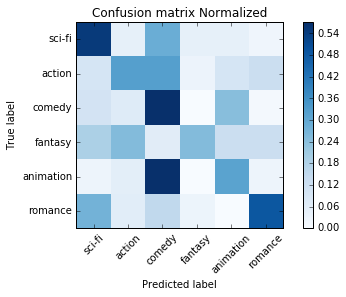

In [41]:
predict(tf_vect, logreg, test_data)

White box vectorizer and classifier are great! We can see what are the most important words for sci-fi. This makes it very easy to tune and debug.

In [43]:
most_influential_words(tf_vect, fantasy_tag_id)

['edward',
 'magical',
 'kingdom',
 'adventures',
 'percy',
 'moving',
 'land',
 'demon',
 'fan',
 'king']

### Things to try with bag of words
Try n-grams with TF-IDF.

For more insight into the model print out the most influential words for a particular plot.

# Averaging word vectors

Now let's use more complex features rather than just counting words.

A great recent achievement of NLP is the [word2vec embedding](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). See Chris Moody's [video](https://www.youtube.com/watch?v=vkfXBGnDplQ) for a great introduction to word2vec. 

First we load a word2vec model. It has been pre-trained by Google on a 100 billon word Google News corpus.  You can play with this model using a fun [web-app](http://rare-technologies.com/word2vec-tutorial/#app)

Vocabulary size: 3 mln words. 

__Warning__: 3 mins to load, takes 4 GB of RAM.

(By the way, one can experiment with other pre-trained models - see nice [list](https://github.com/3Top/word2vec-api/) from 3Top. )

In [44]:
%%time 
wv = Word2Vec.load_word2vec_format(
    "/home/lev/Downloads/GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

2016-05-19 15:07:21,854 : INFO : loading projection weights from /home/lev/Downloads/GoogleNews-vectors-negative300.bin.gz
2016-05-19 15:10:47,235 : INFO : loaded (3000000, 300) matrix from /home/lev/Downloads/GoogleNews-vectors-negative300.bin.gz
2016-05-19 15:10:47,244 : INFO : precomputing L2-norms of word weight vectors


CPU times: user 3min 43s, sys: 4.83 s, total: 3min 48s
Wall time: 3min 52s


Example vocabulary

In [60]:
from itertools import islice
list(islice(wv.vocab, 12000, 12020))

['psychological_evaluations',
 'UFC_lightweights',
 'Turner_Overdrive',
 'Leonardo_DiCaprio_Inception',
 'Llorar_spilling',
 'HEALTH_INFORMATION',
 'pulsa',
 'diocese_vicar',
 'As_Reasonably_Achievable',
 'LAE_reserves',
 'Jessica_Seinfeld_Deceptively',
 'Al_Mahrouqi',
 'Dollar_Erases',
 'OpenCL',
 'Nagging',
 'Hornaman',
 'YSR',
 'Mideast_Unrest',
 'Patricia_Wrice',
 'ambo']

Now we have a vector for each word. How do we get a vector for a sequence of words (aka a document)?


The most naive way is just to take an average. [Mike Tamir](https://www.youtube.com/watch?v=7gTjYwiaJiU) has suggested that the resulting vector points to a single word summarising the whole document. For example all words in a book
 ‘A tale of two cities’ should add up to 'class-struggle’

<img src="images/naivedoc2vec.png">

In [69]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

For word2vec we apply a different tokenization. We want to preserve case as the vocabulary distingushes lower and upper case.

In [70]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [71]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values

In [80]:
%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

CPU times: user 591 ms, sys: 20.8 ms, total: 611 ms
Wall time: 645 ms


Let's see how logistic regression and KNN classifier perform on these word-averaging document features.

In [73]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.tag)


CPU times: user 5.84 ms, sys: 2.95 ms, total: 8.78 ms
Wall time: 12.4 ms


In [81]:
%%time
predicted = knn_naive_dv.predict(X_test_word_average)

CPU times: user 789 ms, sys: 468 ms, total: 1.26 s
Wall time: 1.98 s


accuracy 0.38683127572
confusion matrix
 [[22  4  6  1  6  3]
 [ 9  4  9  4  5  0]
 [18  4 44  3 13  4]
 [ 7  3  1  2  1  2]
 [13  0  9  1 11  1]
 [13  2  1  4  2 11]]
(row=expected, col=predicted)


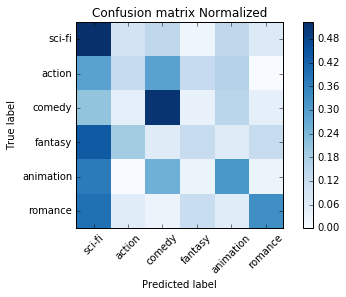

In [75]:
evaluate_prediction(predicted, test_data.tag)

KNN is even worse than the naive 'everything is comedy' baseline! Let's see if logistic regression is better.

In [76]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['tag'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 2 s, sys: 2 ms, total: 2 s
Wall time: 2.01 s


Great! It gives __54%__ accuracy. Best that we have seen so far.

accuracy 0.547325102881
confusion matrix
 [[23  3 11  2  1  2]
 [ 4 10  7  3  3  4]
 [ 2  4 59  3 15  3]
 [ 2  1  2  7  0  4]
 [ 3  1 14  1 14  2]
 [ 5  0  4  2  2 20]]
(row=expected, col=predicted)


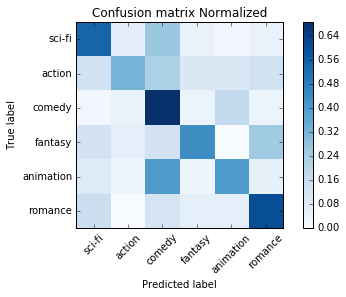

In [77]:
evaluate_prediction(predicted, test_data.tag)

Now just for fun let's see if text summarisation works on our data. Let's pick a plot and see which words it averages to.

In [78]:
test_data.iloc(50)[55]['plot']

"Young Frank and his pals get an idea for the ultimate in excitement. They decide to pool their savings, bicycle to the nearby Big City, and hire some woman of the streets to strip for them. Things do not work out that simply, but they do meet V, a Hooker With A Heart Of Gold, who ends up giving them a ride home. Soon she is living in Frank's treehouse, unbeknownst to Frank's widowed father Tom, who thinks she is one of Frank's teachers. Soon, however, the evil Waltzer comes looking for V."

Hmm... The summarisation doesn't work here because the vector is dominated by stop-words('just', 'the' etc). Try removing stop words and IDF scaling to get better summarisation.

In [82]:
wv.most_similar(positive=[X_test_word_average[55]], restrict_vocab=100000, topn=30)[0:20]

[('just', 0.6429925560951233),
 ('anyway', 0.6323694586753845),
 ('the', 0.6310198307037354),
 ('do', 0.6041447520256042),
 ('that', 0.6029055714607239),
 ('they', 0.601475715637207),
 ('but', 0.594794750213623),
 ('not', 0.5894649028778076),
 ('them', 0.5871086716651917),
 ('so', 0.5829413533210754),
 ('it', 0.5758201479911804),
 ('even', 0.5662525296211243),
 ('actually', 0.5641273856163025),
 ('really', 0.5617256164550781),
 ('he', 0.5608509182929993),
 ('for', 0.5508500337600708),
 ('then', 0.5477421283721924),
 ('if', 0.5427492260932922),
 ('get', 0.5408878922462463),
 ('probably', 0.5385608077049255)]

### Word2vec things to try

Experiment with other pre-trained models - see nice [list](https://github.com/3Top/word2vec-api/) from 3Top. Use Gensim's GloVe converter. Remove stop-words. Do IDF weighting in the averaging function.

# Doc2Vec

A [paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) by Google suggests a model for document classification called Paragraph Vectors Doc2Vec or Doc2vec in short. It is very similar to word2vec. 

It introduces 'a tag' - a word that is in every context in the document.

For our first try we tag every plot with its genre. This makes it 'semi-supervised' learning - the genre labels is just one objective among many.

In [83]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [84]:
train_tagged = train_data.apply(lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [85]:
test_tagged = test_data.apply(lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

This is what a training entry looks like - an example plot tagged by 'sci-fi'.

In [86]:
test_tagged.values[50]

TaggedDocument(words=['troubled', 'psychologist', 'is', 'sent', 'to', 'investigate', 'the', 'crew', 'of', 'an', 'isolated', 'research', 'station', 'orbiting', 'bizarre', 'planet'], tags=['sci-fi'])

In [87]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=2, size=100, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2016-05-19 15:23:36,763 : INFO : collecting all words and their counts
2016-05-19 15:23:36,764 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2016-05-19 15:23:36,865 : INFO : collected 17168 word types and 6 unique tags from a corpus of 2184 examples and 150640 words
2016-05-19 15:23:36,900 : INFO : min_count=5 retains 3631 unique words (drops 13537)
2016-05-19 15:23:36,902 : INFO : min_count leaves 128953 word corpus (85% of original 150640)
2016-05-19 15:23:36,934 : INFO : deleting the raw counts dictionary of 17168 items
2016-05-19 15:23:36,936 : INFO : sample=0 downsamples 0 most-common words
2016-05-19 15:23:36,938 : INFO : downsampling leaves estimated 128953 word corpus (100.0% of prior 128953)
2016-05-19 15:23:36,939 : INFO : estimated required memory for 3631 words and 100 dimensions: 5450100 bytes
2016-05-19 15:23:36,950 : INFO : constructing a huffman tree from 3631 words
2016-05-19 15:23:37,134 : INFO : built huffman tree with maximum node d

CPU times: user 26.2 s, sys: 142 ms, total: 26.3 s
Wall time: 18.2 s


Interesting thing about doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs of the next cell.

Consequently, the accuracy of logistic regression changes when the test set vectors change.

In [189]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 1.05 s, sys: 85.9 ms, total: 1.13 s
Wall time: 1.67 s


accuracy 0.489711934156
confusion matrix
 [[20  1 12  2  4  3]
 [ 3  7 14  2  2  3]
 [ 9  4 57  6  9  1]
 [ 2  2  5  4  3  0]
 [ 2  1 17  2 12  1]
 [ 6  2  5  1  0 19]]
(row=expected, col=predicted)


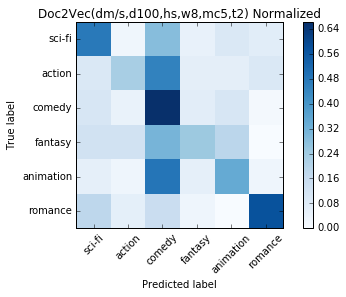

In [190]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

KNN gives a lower accuracy than logistic regression.

2016-05-19 15:24:01,068 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.456790123457
confusion matrix
 [[26  1  3  1  6  5]
 [ 3  9  7  2  5  5]
 [ 9  6 37  6 25  3]
 [ 2  3  3  5  2  1]
 [ 2  3 11  2 16  1]
 [11  1  0  3  0 18]]
(row=expected, col=predicted)
CPU times: user 209 ms, sys: 4.96 ms, total: 214 ms
Wall time: 219 ms


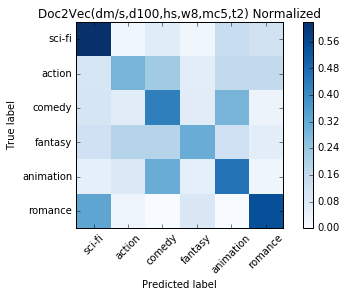

In [90]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Doc2vec gives us a vector for each genre so we can see which genres are close together.

In [91]:
doc2vec_model.docvecs.most_similar('sci-fi')

[('animation', 0.03140611946582794),
 ('action', -0.028109058737754822),
 ('romance', -0.05531027168035507),
 ('fantasy', -0.06388665735721588),
 ('comedy', -0.15815527737140656)]

Words surrounding the 'sci-fi' tag describe it pretty accurately!

In [92]:
doc2vec_model.most_similar([doc2vec_model.docvecs['sci-fi']])

2016-05-19 15:24:04,759 : INFO : precomputing L2-norms of word weight vectors


[('alien', 0.4514704942703247),
 ('express', 0.4008052945137024),
 ('space', 0.40043187141418457),
 ('planet', 0.3805035352706909),
 ('ant', 0.37011784315109253),
 ('ferocious', 0.36217403411865234),
 ('ship', 0.35579410195350647),
 ('hole', 0.3422626256942749),
 ('felt', 0.33965933322906494),
 ('reconnaissance', 0.33902546763420105)]

## Doc2vec things to try
Try tagging every sentence with a unique tag 'SENT_123' and then apply KNN. Try multiple tags per plot.


# Deep IR

'Deep IR' is a technique developed by  [“Document Classification by Inversion of Distributed Language Representations”, Matt Taddy](http://arxiv.org/pdf/1504.07295v3.pdf). Matt has contributed a gensim [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) - great source of more in depth information.

In short the algorithm is:

1. Train a word2vec model only on comedy plots.

2. Trian another model only on sci-fi, another on romance etc. Get 6 models - one for each genre.

3. Take a plot and see which model fits it best using Bayes' Theorem



The tokenization is different from other methods. The reason for this is that we are following an original approach in the paper. The purpose of this tutorial is to see how the models behave out of the box.

We just clean non-alphanumeric characters and split by sentences.

In [93]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")


In [94]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_data
    else:
        my_df = test_data
    for i, row in my_df.iterrows():
        yield {'y':row['tag'],\
        'x':[clean(s).split() for s in sentences(row['plot'])]}


In [97]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

CPU times: user 1.11 s, sys: 10 ms, total: 1.12 s
Wall time: 1.12 s


In [98]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [99]:
def tag_sentences(reviews, stars=my_tags):  
    for r in reviews:
        if r['y'] in stars:
            for s in r['x']:
                yield s

An example `sci-fi` sentence:

In [104]:
next(tag_sentences(revtrain, my_tags[0]))

['during',
 'manned',
 'mission',
 'to',
 'mars',
 'astronaut',
 'mark',
 'watney',
 'is',
 'presumed',
 'dead',
 'after',
 'fierce',
 'storm',
 'and',
 'left',
 'behind',
 'by',
 'his',
 'crew']

We train our own 6 word2vec models from scratch. 

In [107]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner 
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count(), # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup
    
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "genre (", len(slist), ")")
    genremodels[i].train(  slist, total_examples=len(slist) )
# get the probs (note we give docprob a list of lists of words, plus the models)


2016-05-19 15:31:37,751 : INFO : collecting all words and their counts
2016-05-19 15:31:37,753 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-05-19 15:31:37,799 : INFO : collected 17544 word types from a corpus of 148422 raw words and 7880 sentences
2016-05-19 15:31:37,836 : INFO : min_count=5 retains 3647 unique words (drops 13897)
2016-05-19 15:31:37,839 : INFO : min_count leaves 126255 word corpus (85% of original 148422)
2016-05-19 15:31:37,865 : INFO : deleting the raw counts dictionary of 17544 items
2016-05-19 15:31:37,867 : INFO : sample=0.001 downsamples 42 most-common words
2016-05-19 15:31:37,868 : INFO : downsampling leaves estimated 91197 word corpus (72.2% of prior 126255)
2016-05-19 15:31:37,872 : INFO : estimated required memory for 3647 words and 100 dimensions: 5470500 bytes
2016-05-19 15:31:37,884 : INFO : constructing a huffman tree from 3647 words


Word2Vec(vocab=0, size=100, alpha=0.025)


2016-05-19 15:31:38,090 : INFO : built huffman tree with maximum node depth 15
2016-05-19 15:31:38,095 : INFO : resetting layer weights
2016-05-19 15:31:38,955 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0


sci-fi genre ( 1157 )


2016-05-19 15:31:39,969 : INFO : PROGRESS: at 32.77% examples, 433036 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:40,978 : INFO : PROGRESS: at 68.32% examples, 450734 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:41,833 : INFO : worker thread finished; awaiting finish of 3 more threads
2016-05-19 15:31:41,841 : INFO : worker thread finished; awaiting finish of 2 more threads
2016-05-19 15:31:41,847 : INFO : worker thread finished; awaiting finish of 1 more threads
2016-05-19 15:31:41,854 : INFO : worker thread finished; awaiting finish of 0 more threads
2016-05-19 15:31:41,854 : INFO : training on 2163100 raw words (1330227 effective words) took 2.9s, 459852 effective words/s
2016-05-19 15:31:41,857 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0


action genre ( 1370 )


2016-05-19 15:31:42,878 : INFO : PROGRESS: at 28.31% examples, 447395 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:43,887 : INFO : PROGRESS: at 57.74% examples, 456921 words/s, in_qsize 8, out_qsize 0
2016-05-19 15:31:44,904 : INFO : PROGRESS: at 84.50% examples, 444533 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:45,494 : INFO : worker thread finished; awaiting finish of 3 more threads
2016-05-19 15:31:45,512 : INFO : worker thread finished; awaiting finish of 2 more threads
2016-05-19 15:31:45,524 : INFO : worker thread finished; awaiting finish of 1 more threads
2016-05-19 15:31:45,534 : INFO : worker thread finished; awaiting finish of 0 more threads
2016-05-19 15:31:45,536 : INFO : training on 2577000 raw words (1598436 effective words) took 3.7s, 435517 effective words/s
2016-05-19 15:31:45,542 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0


comedy genre ( 2375 )


2016-05-19 15:31:46,550 : INFO : PROGRESS: at 16.56% examples, 458483 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:47,573 : INFO : PROGRESS: at 26.98% examples, 368630 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:48,574 : INFO : PROGRESS: at 37.60% examples, 343758 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:49,577 : INFO : PROGRESS: at 54.18% examples, 372148 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:50,583 : INFO : PROGRESS: at 70.99% examples, 390045 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:51,586 : INFO : PROGRESS: at 88.24% examples, 404280 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:52,240 : INFO : worker thread finished; awaiting finish of 3 more threads
2016-05-19 15:31:52,242 : INFO : worker thread finished; awaiting finish of 2 more threads
2016-05-19 15:31:52,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2016-05-19 15:31:52,260 : INFO : worker thread finished; awaiting finish of 0 more threads
2016-05-19 15:31:5

fantasy genre ( 707 )


2016-05-19 15:31:53,295 : INFO : PROGRESS: at 52.15% examples, 425718 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:54,111 : INFO : worker thread finished; awaiting finish of 3 more threads
2016-05-19 15:31:54,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2016-05-19 15:31:54,124 : INFO : worker thread finished; awaiting finish of 1 more threads
2016-05-19 15:31:54,133 : INFO : worker thread finished; awaiting finish of 0 more threads
2016-05-19 15:31:54,136 : INFO : training on 1340700 raw words (822354 effective words) took 1.8s, 444793 effective words/s
2016-05-19 15:31:54,139 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0


animation genre ( 867 )


2016-05-19 15:31:55,155 : INFO : PROGRESS: at 44.21% examples, 428879 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:56,170 : INFO : PROGRESS: at 92.15% examples, 444071 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:56,312 : INFO : worker thread finished; awaiting finish of 3 more threads
2016-05-19 15:31:56,325 : INFO : worker thread finished; awaiting finish of 2 more threads
2016-05-19 15:31:56,331 : INFO : worker thread finished; awaiting finish of 1 more threads
2016-05-19 15:31:56,333 : INFO : worker thread finished; awaiting finish of 0 more threads
2016-05-19 15:31:56,335 : INFO : training on 1604300 raw words (972761 effective words) took 2.2s, 445688 effective words/s
2016-05-19 15:31:56,337 : INFO : training model with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0


romance genre ( 1404 )


2016-05-19 15:31:57,360 : INFO : PROGRESS: at 26.85% examples, 432041 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:58,372 : INFO : PROGRESS: at 54.08% examples, 434994 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:59,374 : INFO : PROGRESS: at 82.44% examples, 443972 words/s, in_qsize 7, out_qsize 0
2016-05-19 15:31:59,962 : INFO : worker thread finished; awaiting finish of 3 more threads
2016-05-19 15:31:59,971 : INFO : worker thread finished; awaiting finish of 2 more threads
2016-05-19 15:31:59,973 : INFO : worker thread finished; awaiting finish of 1 more threads
2016-05-19 15:31:59,978 : INFO : worker thread finished; awaiting finish of 0 more threads
2016-05-19 15:31:59,979 : INFO : training on 2641400 raw words (1630184 effective words) took 3.6s, 448856 effective words/s


CPU times: user 1min 10s, sys: 309 ms, total: 1min 10s
Wall time: 22.2 s


Now we will compute most likely class for a plot using Bayes' Theorem formula.

<img src='images/deep_ir_bayes.png' width=600>

For any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences. This is all in the following handy wrapper. (from the original [tutorial](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/deepir.ipynb) by Matt Taddy.

In [187]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [188]:
%%time
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

2016-05-19 18:02:35,484 : INFO : scoring sentences with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2016-05-19 18:02:35,578 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2016-05-19 18:02:35,876 : INFO : scoring 894 sentences took 0.4s, 2321 sentences/s
2016-05-19 18:02:35,879 : INFO : scoring sentences with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2016-05-19 18:02:35,916 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2016-05-19 18:02:36,179 : INFO : scoring 894 sentences took 0.3s, 2998 sentences/s
2016-05-19 18:02:36,181 : INFO : scoring sentences with 4 workers on 3647 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2016-05-19 18:02:36,231 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2016-05-19 18:02:36,537 : INFO : scoring 894 sentences took 0.4s, 2518 sentences/s
2016-05-19 18:02:36,540 : INFO : s

CPU times: user 437 ms, sys: 408 ms, total: 845 ms
Wall time: 2.04 s


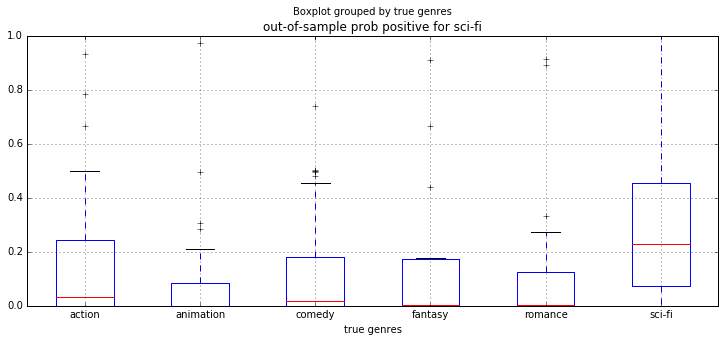

In [116]:
tag_index = 0
col_name = "out-of-sample prob positive for " + my_tags[tag_index]
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "true genres": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="true genres", figsize=(12,5))

In [112]:
target = [r['y'] for r in revtest]

accuracy 0.275720164609
confusion matrix
 [[14  3  3  7  8  7]
 [ 1  5  8  7  7  3]
 [ 7 12 27  7 20 13]
 [ 6  3  1  2  1  3]
 [ 7  3 10  3  9  3]
 [ 4  7  6  3  3 10]]
(row=expected, col=predicted)


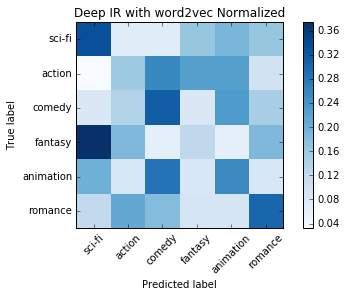

In [117]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")

Performance is worse than for a naive predictor that says that everything is `comedy`. It is because we train each word2vec model from scratch on a very small sample of about 30k words.

This model needs more data.

# Word Mover's Distance

<img src='images/wmd_gelato.png'>

Image from 
http://tech.opentable.com/2015/08/11/navigating-themes-in-restaurant-reviews-with-word-movers-distance/

Word Mover's Distance is a new algorithm developed in by [Matt Kusner](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf). There is Matt's code on [github](https://github.com/mkusner/wmd) and also Gensim can compute WMD similarity in this [PR](https://github.com/piskvorky/gensim/pull/659).

For KNN the best code is from [Vlad Niculae's blog](http://vene.ro/blog/word-movers-distance-in-python.html). He is a contributor to sklearn and did great integration of WMD with sklearn KNN.

__Warning__: Write 7 GB file on disk to use memory mapping.

## __This part requires Python 3__

In [121]:
%%time

data_folder = '/data/'

fp = np.memmap(data_folder + "embed.dat", dtype=np.double, mode='w+', shape=wv.syn0norm.shape)
fp[:] = wv.syn0norm[:]

with smart_open(data_folder + "embed.vocab", "w") as f: 
    for _, w in sorted((voc.index, word) for word, voc in wv.vocab.items()):
        print(w.encode('utf8'), file=f)
del fp, wv

CPU times: user 25.6 s, sys: 7.58 s, total: 33.2 s
Wall time: 3min 36s


In [151]:
W = np.memmap(data_folder + "embed.dat", dtype=np.double, mode="r", shape=(3000000, 300))
with smart_open(data_folder + "embed.vocab", mode="rb") as f:
    vocab_list = [line.strip() for line in f]

In [152]:
vocab_dict = {w: k for k, w in enumerate(vocab_list)}

### sklearn KNN integration with WMD

In [124]:
"""%%file word_movers_knn.py"""

# Authors: Vlad Niculae, Matt Kusner
# License: Simplified BSD

import numpy as np
from sklearn.metrics import euclidean_distances
from sklearn.externals.joblib import Parallel, delayed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import check_array
from sklearn.cross_validation import check_cv
from sklearn.metrics.scorer import check_scoring
from sklearn.preprocessing import normalize

from pyemd import emd


class WordMoversKNN(KNeighborsClassifier):
    """K nearest neighbors classifier using the Word Mover's Distance.

    Parameters
    ----------
    
    W_embed : array, shape: (vocab_size, embed_size)
        Precomputed word embeddings between vocabulary items.
        Row indices should correspond to the columns in the bag-of-words input.

    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for :meth:`k_neighbors` queries.

    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run for Word Mover's Distance computation.
        If ``-1``, then the number of jobs is set to the number of CPU cores.
    
    verbose : int, optional
        Controls the verbosity; the higher, the more messages. Defaults to 0.
        
    References
    ----------
    
    Matt J. Kusner, Yu Sun, Nicholas I. Kolkin, Kilian Q. Weinberger
    From Word Embeddings To Document Distances
    The International Conference on Machine Learning (ICML), 2015
    http://mkusner.github.io/publications/WMD.pdf
    
    """
    _pairwise = False

    def __init__(self, W_embed, n_neighbors=1, n_jobs=1, verbose=False):
        self.W_embed = W_embed
        self.verbose = verbose
        super(WordMoversKNN, self).__init__(n_neighbors=n_neighbors, n_jobs=n_jobs,
                                            metric='precomputed', algorithm='brute')

    def _wmd(self, i, row, X_train):
        """Compute the WMD between training sample i and given test row.
        
        Assumes that `row` and train samples are sparse BOW vectors summing to 1.
        """
        union_idx = np.union1d(X_train[i].indices, row.indices)
        W_minimal = self.W_embed[union_idx]
        W_dist = euclidean_distances(W_minimal)
        bow_i = X_train[i, union_idx].A.ravel()
        bow_j = row[:, union_idx].A.ravel()
        return emd(bow_i, bow_j, W_dist)
    
    def _wmd_row(self, row, X_train):
        """Wrapper to compute the WMD of a row with all training samples.
        
        Assumes that `row` and train samples are sparse BOW vectors summing to 1.
        Useful for parallelization.
        """
        n_samples_train = X_train.shape[0]
        return [self._wmd(i, row, X_train) for i in range(n_samples_train)]

    def _pairwise_wmd(self, X_test, X_train=None):
        """Computes the word mover's distance between all train and test points.
        
        Parallelized over rows of X_test.
        
        Assumes that train and test samples are sparse BOW vectors summing to 1.
        
        Parameters
        ----------
        X_test: scipy.sparse matrix, shape: (n_test_samples, vocab_size)
            Test samples.
        
        X_train: scipy.sparse matrix, shape: (n_train_samples, vocab_size)
            Training samples. If `None`, uses the samples the estimator was fit with.
        
        Returns
        -------
        dist : array, shape: (n_test_samples, n_train_samples)
            Distances between all test samples and all train samples.
        
        """
        n_samples_test = X_test.shape[0]
        
        if X_train is None:
            X_train = self._fit_X

        dist = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
            delayed(self._wmd_row)(test_sample, X_train)
            for test_sample in X_test)

        return np.array(dist)

    def fit(self, X, y):
        """Fit the model using X as training data and y as target values

        Parameters
        ----------
        X : scipy sparse matrix, shape: (n_samples, n_features)
            Training data. 

        y : {array-like, sparse matrix}
            Target values of shape = [n_samples] or [n_samples, n_outputs]

        """
        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)
        return super(WordMoversKNN, self).fit(X, y)

    def predict(self, X):
        """Predict the class labels for the provided data
        Parameters
        ----------
        X : scipy.sparse matrix, shape (n_test_samples, vocab_size)
            Test samples.

        Returns
        -------
        y : array of shape [n_samples]
            Class labels for each data sample.
        """
        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)
        dist = self._pairwise_wmd(X)
        return super(WordMoversKNN, self).predict(dist)
    
    
class WordMoversKNNCV(WordMoversKNN):
    """Cross-validated KNN classifier using the Word Mover's Distance.

    Parameters
    ----------
    W_embed : array, shape: (vocab_size, embed_size)
        Precomputed word embeddings between vocabulary items.
        Row indices should correspond to the columns in the bag-of-words input.

    n_neighbors_try : sequence, optional
        List of ``n_neighbors`` values to try.
        If None, tries 1-5 neighbors.

    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, StratifiedKFold is used.

    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run for Word Mover's Distance computation.
        If ``-1``, then the number of jobs is set to the number of CPU cores.

    verbose : int, optional
        Controls the verbosity; the higher, the more messages. Defaults to 0.

    Attributes
    ----------
    cv_scores_ : array, shape (n_folds, len(n_neighbors_try))
        Test set scores for each fold.

    n_neighbors_ : int,
        The best `n_neighbors` value found.

    References
    ----------

    Matt J. Kusner, Yu Sun, Nicholas I. Kolkin, Kilian Q. Weinberger
    From Word Embeddings To Document Distances
    The International Conference on Machine Learning (ICML), 2015
    http://mkusner.github.io/publications/WMD.pdf
    
    """
    def __init__(self, W_embed, n_neighbors_try=None, scoring=None, cv=3,
                 n_jobs=1, verbose=False):
        self.cv = cv
        self.n_neighbors_try = n_neighbors_try
        self.scoring = scoring
        super(WordMoversKNNCV, self).__init__(W_embed,
                                              n_neighbors=None,
                                              n_jobs=n_jobs,
                                              verbose=verbose)

    def fit(self, X, y):
        """Fit KNN model by choosing the best `n_neighbors`.
        
        Parameters
        -----------
        X : scipy.sparse matrix, (n_samples, vocab_size)
            Data
        y : ndarray, shape (n_samples,) or (n_samples, n_targets)
            Target
        """
        if self.n_neighbors_try is None:
            n_neighbors_try = range(1, 6)
        else:
            n_neighbors_try = self.n_neighbors_try

        X = check_array(X, accept_sparse='csr', copy=True)
        X = normalize(X, norm='l1', copy=False)

        cv = check_cv(self.cv, X, y)
        knn = KNeighborsClassifier(metric='precomputed', algorithm='brute')
        scorer = check_scoring(knn, scoring=self.scoring)

        scores = []
        for train_ix, test_ix in cv:
            dist = self._pairwise_wmd(X[test_ix], X[train_ix])
            knn.fit(X[train_ix], y[train_ix])
            scores.append([
                scorer(knn.set_params(n_neighbors=k), dist, y[test_ix])
                for k in n_neighbors_try
            ])
        scores = np.array(scores)
        self.cv_scores_ = scores

        best_k_ix = np.argmax(np.mean(scores, axis=0))
        best_k = n_neighbors_try[best_k_ix]
        self.n_neighbors = self.n_neighbors_ = best_k

        return super(WordMoversKNNCV, self).fit(X, y)

Let's see how well it performs.

In [140]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values

flat_train_tokenized = [item for sublist in train_tokenized for item in sublist]
flat_test_tokenized = [item for sublist in test_tokenized for item in sublist]


To speed up performance we focus only on the words that are both in Google News model and in our dataset.

In [186]:
# the word2vec model was loaded with strings as byte-arrays so need to convert
def convert_to_vocab_bytes(s):
     return bytes("b'" + s + "'", encoding='utf-8')    

In [172]:
vect = CountVectorizer(stop_words="english").fit(flat_train_tokenized)
common = [word for word in vect.get_feature_names() if convert_to_vocab_bytes(word) in vocab_dict]
W_common = W[[vocab_dict[ convert_to_vocab_bytes(w)] for w in common]]

The mass of the pile of mud in the Word Mover's Distance is determined by how many times a word appears in a document. So we need a CountVectorizer.

In [180]:
test_tokenized[0]

"English rock star Aldous Snow relapses into drugs and booze after break up and disastrous record In L.A. Aaron Green works for record company stuck in recession Aaron 's boss gives him career making task to bring Aldous from London to L.A. for concert in 72 hours That day Aaron 's girlfriend Daphne tells him she wants to finish her medical residency in Seattle Aaron 's sure this ends their relationship In London things are n't much better Aldous delays their departure several times plies Aaron with vices and alternates between bad behavior and trenchant observations Can Aaron moderate Aldous 's substance abuse and get him to the Greek What about Daphne"

In [181]:
vect = CountVectorizer(vocabulary=common, dtype=np.double)
X_train = vect.fit_transform(train_tokenized)
X_test = vect.transform(test_tokenized)

Let's train the model.

In [182]:
knn = WordMoversKNN(n_neighbors=1,W_embed=W_common, verbose=5, n_jobs=7)

In [183]:
knn.fit(X_train, train_data['tag'])

WordMoversKNN(W_embed=memmap([[ 0.08538,  0.02645, ..., -0.00401,  0.02777],
       [ 0.1002 ,  0.02656, ..., -0.01125,  0.01431],
       ...,
       [-0.03055,  0.00673, ...,  0.01588,  0.01891],
       [-0.00325,  0.07331, ...,  0.11209,  0.08234]]),
       n_jobs=7, n_neighbors=1, verbose=5)

__Warning__: 10 minutes runtime on 7 cores, 1 hour on 4 core laptop

In [185]:
%%time 
predicted = knn.predict(X_test)

[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  3.4min
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed: 21.3min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 51.8min
[Parallel(n_jobs=7)]: Done 243 out of 243 | elapsed: 70.7min finished


CPU times: user 18.7 s, sys: 37.7 s, total: 56.4 s
Wall time: 1h 10min 45s


Only 2% above the naive baseline unfortunately. It gets sci-fi and romance really cleanly though.

WMD achieved good results on sentiment analysis in the published paper. Maybe it works better for sentiment than for topic classification that we use it here. Or maybe preprocessing can be tuned here. It is hard to debug a black box method!

accuracy 0.38683127572
confusion matrix
 [[21  2 10  4  3  2]
 [ 3  8 11  2  3  4]
 [16  6 32  8 18  6]
 [ 3  2  5  3  1  2]
 [ 8  2 11  1 12  1]
 [ 1  4  1  6  3 18]]
(row=expected, col=predicted)


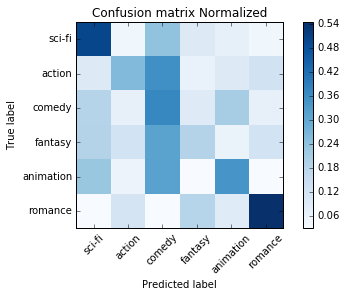

In [191]:
evaluate_prediction(predicted, test_data['tag'])

# Conclusion

Above we shown how to run 'hello-world' in 7 different document classification techniques. It is just a beginning of exploration of their features... There are a lot of parameters that can be tuned to get the best possible results out of them. The 'hello-world' run is in no way an indication of their best peformance. The goal of this tutorial is to show the API so you can start tuning them yourself.

Out of the box "no tuning" accuracy of bag of words is not far behind more advanced techniques. 
Tune them and the pre-processing for them well first and only then reach for more advanced methods if more accuracy is absolutely needed.